<h1><center>OSDA Homework</center></h1>
<h2><center>Yuryeva Irina</center></h2>

## 1. Datasets information

<b>Dataset:</b> 1   
<b>Name: </b>"Congressional Voting Records Data Set" <br>
<b>Link: </b>https://archive.ics.uci.edu/ml/datasets/congressional+voting+records <br>
<b>Number of instances:</b> 435 <br>
<b>Number of attributes:</b> 16 <br>
<b>Missing values: </b> Yes <br>

<b>Dataset: </b> 2  
<b>Name: </b>"Tic-Tac-Toe Endgame Data Set" <br>
<b>Link: </b>https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame<br>
<b>Number of instances:</b> 958 <br>
<b>Number of attributes:</b> 27 <br>
<b>Missing values: </b> No <br>

## 2. Datasets preparation


### 2.1 Importing datasets

In [30]:
import pandas as pd
import numpy as np

# Congressional Voting Records Data Set
df_1 = pd.read_csv(
    filepath_or_buffer="http://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data", 
    header=None, 
    sep=',')
headers = ['target', 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
df_1.columns = headers

# Tic-Tac-Toe Endgame Data Set
df_2 = pd.read_csv(
    filepath_or_buffer="https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data", 
    header=None, 
    sep=',')
headers_2 = [1,2,3,4,5,6,7,8,9,'target']
df_2.columns = headers_2

### 2.2 Preparation of datasets

#### 2.2.1 Preparation of Congressional Voting Records Data Set
Changing string values to variables and deleting rows with NaNs.

In [31]:
df_1 = df_1.replace('?', np.nan)
df_1 = df_1.replace('y', True)
df_1 = df_1.replace('n', False)
df_1 = df_1.dropna().reset_index(drop=True)
df_1 = df_1.replace('democrat', True)
df_1 = df_1.replace('republican', False)
df_1 = df_1[list(df_1.columns.values)].astype('bool')

#### 2.2.2 Preparation of Tic-Tac-Toe Dataset
Getting dummy features from all features and changing string values to bool variables

In [32]:
df_2 = df_2.replace('positive', True)
df_2 = df_2.replace('negative', False)
df_2 = pd.get_dummies(df_2, columns=[1,2,3,4,5,6,7,8,9])
df_2 = df_2[list(df_2.columns.values)].astype('bool')

### 2.3 Saving prepared datasets 

In [33]:
import os

directory = r'/Users/upayuryva/PycharmProjects/pythonProject3/datasets'
df_1.to_csv(os.path.join(directory, r'cvrds.csv'), index=False)
df_2.to_csv(os.path.join(directory, r'ttt.csv'), index=False)

## 3. Supporting functions

### 3.1 Cross-Validation function


In [34]:
from sklearn import model_selection
import sys

def cross_validation(path_in, path_out, dataset_short_name, n_splits):
    
    df_prep = pd.read_csv(path_in)
    kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=None)
    kf.get_n_splits(df_prep)
    k = 1
    
    for train_index, test_index in kf.split(df_prep):
        df_prep.iloc[train_index].to_csv(os.path.join(path_out, dataset_short_name+'_train_'+str(k)+'.csv'),index=False)
        df_prep.iloc[test_index].to_csv(os.path.join(path_out, dataset_short_name+'_test_'+str(k)+'.csv'),index=False)
        k += 1
        
    return 'Cross Validation Completed'

### 3.2 Data preprocessing

In [35]:
def data_preprocessing(path_train, path_test, target_column = 'target'):
    
    train = pd.read_csv(path_train)
    test = pd.read_csv(path_test)
    test_target = pd.read_csv(path_test)
    test_target = test_target[target_column].to_numpy()
    
    plus_context = train[train[target_column] == True]
    minus_context = train[train[target_column] == False]

    plus_context = plus_context.drop(target_column, axis = 1).to_numpy()
    minus_context = minus_context.drop(target_column, axis = 1).to_numpy()
    test = test.drop(target_column, axis = 1).to_numpy()
    
    return plus_context, minus_context, test, test_target

### 3.3 Supporting functions for algorithm 

In [36]:
def intersection(set_1, set_2):
    intersec = np.equal(set_1, set_2)
    intersec_ind = [i for i,x in enumerate(intersec) if x]
    return intersec, intersec_ind 


def add_score(first_context, second_context, test_row, t, alg_num, t_intersec=0):
    score = 0
    max_n_true = 0
    for f_row in first_context:
        intersec_first, intersec_first_ind = intersection(test_row, f_row)
        n_true = 0
        
        intersec_first_len_norm = np.sum(intersec_first)/len(test_row)
        if alg_num in [1,2]:
            if alg_num == 1 or intersec_first_len_norm >= t_intersec:
                for s_row in second_context:
                    intersec_second, intersec_second_ind = intersection(f_row, s_row)
                    if set(intersec_first_ind).issubset(set(intersec_second_ind)):
                        n_true += 1
                if n_true <= t: 
                    score += 1
        
        if alg_num == 3:
            if intersec_first_len_norm < t_intersec:
                continue
            for s_row in second_context:
                intersec_second, intersec_second_ind = intersection(f_row, s_row)
                if set(intersec_first_ind).issubset(set(intersec_second_ind)):
                    n_true += 1
                    max_n_true = max(n_true, max_n_true)
            score = max_n_true
            
    return score

### 3.4 Metrics test

In [37]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def metrics_test(y_real, y_pred):
    acc = accuracy_score(y_real, y_pred)
    roc_auc = roc_auc_score(y_real, y_pred)
    prc = precision_score(y_real, y_pred)
    rcl = recall_score(y_real, y_pred)
    return acc, roc_auc, prc, rcl

## 4. Algorithms

### 4.1 Algorithm 1

Algorithm based on voting system, where every plus context object votes for plus classification, if its intersection with test object is not a subset(depending on thresholds) of of minus context and vice versa.
Test object classifies positive, if there is more votes for plus classification (and vice versa).
There is one threshold, which controls, how many subsets of plus/minus and test sets intersection can be in minus/plus context

In [38]:
from random import choice

def alg_1(test, plus_context, minus_context, threshold=0):
    norm_plus = (len(plus_context)+len(minus_context))//len(plus_context)
    norm_minus = (len(plus_context)+len(minus_context))//len(minus_context)
    plus_score = 0 
    minus_score = 0 
    random_counter = 0 
    predict = []
    for test_row in test:
        plus_score = add_score(plus_context, minus_context, test_row, threshold, 1)
        plus_score *= norm_plus
        minus_score = add_score(minus_context, plus_context, test_row, threshold, 1)
        minus_score *= norm_minus
        if plus_score > minus_score:
            predict.append(True)
        elif plus_score < minus_score:
            predict.append(False)
        elif plus_score == minus_score:
            predict.append(choice([False,True]))
            random_counter += 1
    randomness = random_counter/len(test)
    return predict, randomness

### 4.2 Algorithm 2

Algorithm based on voting system, where eveery plus context object votes for plus classification, if its intersection(depending on threshold) with test object is not a subset(depending on threshold) of of minus context and vice versa. Test set is True, if there is more votes for plus classification (and vice versa).

In [39]:
def alg_2(test, plus_context, minus_context, threshold, threshold_intersec):
    norm_plus = (len(plus_context)+len(minus_context))//len(plus_context)
    norm_minus = (len(plus_context)+len(minus_context))//len(minus_context)
    plus_score = 0 
    minus_score = 0 
    random_counter = 0 
    predict = []
    for test_row in test:
        plus_score = add_score(plus_context, minus_context, test_row, threshold, 2, threshold_intersec)
        plus_score *= norm_plus
        minus_score = add_score(minus_context, plus_context, test_row, threshold, 2, threshold_intersec)
        minus_score *= norm_minus
        if plus_score > minus_score:
            predict.append(True)
        elif plus_score < minus_score:
            predict.append(False)
        elif plus_score == minus_score:
            predict.append(choice([False,True]))
            random_counter += 1
    randomness = random_counter/len(test)
    return predict, randomness

### 4.3 Algorithm 3
Algorithm classifies test object by maximum subset of plus/minus context object and test object intersection in minus/plus context object.
Test object is True, if there is more votes for plus classification (and vice versa).
It has threshold_intersec, which controls, how many elements can be in plus/minus context and test sets intersection.

In [40]:
def alg_3(test, plus_context, minus_context, threshold, threshold_intersec):
    plus_score = 0 
    minus_score = 0 
    random_counter = 0 
    predict = []
    for test_row in test:
        plus_score = add_score(plus_context, minus_context, test_row, threshold, 3, threshold_intersec)
        minus_score = add_score(minus_context, plus_context, test_row, threshold, 3, threshold_intersec)
        if plus_score < minus_score:
            predict.append(True)
        elif plus_score > minus_score:
            predict.append(False)
        elif plus_score == minus_score:
            predict.append(choice([False,True]))
            random_counter += 1
    
    randomness = random_counter/len(test)
    return predict, randomness

### 4.4 BernoulliNB Algorithm

In [41]:
from sklearn.naive_bayes import BernoulliNB

def bernoulliNB(dataset_shortname):
    cv_path = '/Users/upayuryva/PycharmProjects/pythonProject3/cross_validated/'
    y_pred_arr = []
    metrics = []
    for i in range(1,11):
        test = pd.read_csv(cv_path+dataset_shortname+r'_test_'+str(i)+r'.csv')
        train = pd.read_csv(cv_path+dataset_shortname+r'_train_'+str(i)+r'.csv')
        
        X_train = train.drop('target', axis = 1).to_numpy()
        y_train = train['target'].to_numpy()
        
        X_test = test.drop('target', axis = 1).to_numpy()
        y_test = test['target'].to_numpy()
        
        clf = BernoulliNB()
        clf.fit(X_train, y_train)
        
        y_pred = clf.predict(X_test)
        
        acc, roc_auc, prc, rcl = metrics_test(y_pred, y_test)
        metrics.append([acc, roc_auc, prc, rcl, 0])
        y_pred_arr.append(y_pred)
        
    return y_pred_arr, y_test, metrics

## 5. Check algorithm

In [42]:
def alg_eval(dataset_shortname, alg_n, threshold_subset, threshold_intersec=0, is_already_cv = True):

    ds_path = '/Users/upayuryva/PycharmProjects/pythonProject3/datasets/'
    cv_path = '/Users/upayuryva/PycharmProjects/pythonProject3/cross_validated/'
    
    metrics = []
    y_pred_arr = []
    n_splits = 10
    
    #cross validation
    if not is_already_cv:
        cross_validation(path_in=ds_path+dataset_shortname+r'.csv', 
                         path_out=cv_path,
                         dataset_short_name=dataset_shortname, 
                         n_splits=10)
    for i in range(1,n_splits+1):
        # data preprosessing
        plus_context, minus_context, test, test_target = data_preprocessing(path_train=cv_path+dataset_shortname+r'_train_'+str(i)+r'.csv',
                                                                          path_test=cv_path+dataset_shortname+r'_test_'+str(i)+r'.csv')
        
        # algorithm
        y_real = test_target
        
        if alg_n == 1:
            y_pred, randomness = alg_1(test, plus_context, minus_context, threshold_subset)
        if alg_n == 2:
            y_pred, randomness = alg_2(test, plus_context, minus_context, threshold_subset, threshold_intersec)
        if alg_n == 3:
            y_pred, randomness = alg_3(test, plus_context, minus_context, threshold_subset, threshold_intersec)
        # metrics
        acc, roc_auc, prc, rcl = metrics_test(y_pred, y_real)
        metrics.append([acc, roc_auc, prc, rcl, randomness])
        #y_pred_arr.append(y_pred)
        
    return y_pred, y_real, metrics


## 6. Find optimal parameters

In [43]:
def avg_metrics(metrics):
    np_metrics = np.array(metrics)
    return np.mean(np_metrics, axis=0)

def print_metrics(metrics):
    print('Accuracy score: {:.4f}'.format(metrics[0]))
    print('Roc AUC Score: {:.4f}'.format(metrics[1]))
    print('Precision Score: {:.4f}'.format(metrics[2]))
    print('Recall Score: {:.4f}'.format(metrics[3]))
    print('Randomness: {:.4f}'.format(metrics[4]))

In [55]:
import matplotlib.pyplot as plt
import sys

def plot_show(array_avg):
    plt.plot(array_avg)
    plt.legend(['Accuracy score', 'ROC AUC', 'Precision','Recall', 'Randomness'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid()
    plt.show()

def hp_tuning(dataset_shortname, alg_n):
    avg_m_arr = np.empty((0,5), float)
    if alg_n == 1:
        for i in range(0,5):
            _, _, metrics = alg_eval(dataset_shortname=dataset_shortname, alg_n=alg_n, threshold_subset=i)
            avg_m = avg_metrics(metrics)
            avg_m_arr = np.vstack([avg_m_arr, avg_m])
    else:
        for i in np.arange(0, 1.1, 0.1):
            _, _, metrics = alg_eval(dataset_shortname=dataset_shortname, alg_n=alg_n, threshold_subset=0, threshold_intersec=i)
            avg_m = avg_metrics(metrics)
            avg_m_arr = np.vstack([avg_m_arr, avg_m])
    
    plot_show(avg_m_arr)
    
    return avg_m_arr

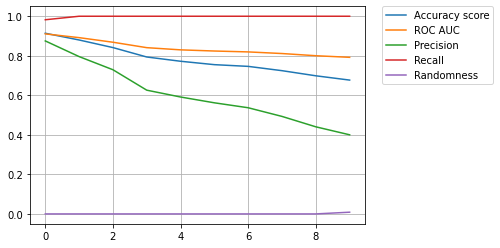

array([[0.91394928, 0.91074634, 0.87511889, 0.98222222, 0.        ],
       [0.8798913 , 0.89175325, 0.79587462, 1.        , 0.        ],
       [0.84148551, 0.86853584, 0.72937279, 1.        , 0.        ],
       [0.79384058, 0.84105769, 0.6260205 , 1.        , 0.        ],
       [0.77228261, 0.8299697 , 0.59139837, 1.        , 0.        ],
       [0.75507246, 0.82407425, 0.56206863, 1.        , 0.        ],
       [0.74637681, 0.81956681, 0.53706863, 1.        , 0.        ],
       [0.72463768, 0.81134491, 0.49320898, 1.        , 0.        ],
       [0.69873188, 0.80027947, 0.44058994, 1.        , 0.        ],
       [0.67699275, 0.79217145, 0.40019311, 1.        , 0.00869565]])

In [47]:
hp_tuning('cvrds', 1)

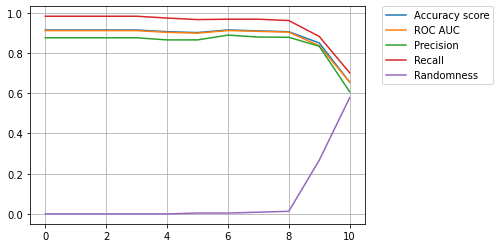

array([[0.91394928, 0.91074634, 0.87511889, 0.98222222, 0.        ],
       [0.91394928, 0.91074634, 0.87511889, 0.98222222, 0.        ],
       [0.91394928, 0.91074634, 0.87511889, 0.98222222, 0.        ],
       [0.91394928, 0.91074634, 0.87511889, 0.98222222, 0.        ],
       [0.90543478, 0.90219017, 0.8646488 , 0.97333333, 0.        ],
       [0.90108696, 0.89834402, 0.8646488 , 0.96564103, 0.00434783],
       [0.91413043, 0.91114261, 0.88850235, 0.96745921, 0.00434783],
       [0.90960145, 0.90712704, 0.87879474, 0.96745921, 0.00851449],
       [0.90525362, 0.90318931, 0.87760427, 0.9608658 , 0.01304348],
       [0.84945652, 0.83546967, 0.8332514 , 0.88187007, 0.26648551],
       [0.65507246, 0.65542908, 0.60708149, 0.70123945, 0.57735507]])

In [48]:
hp_tuning('cvrds', 2)

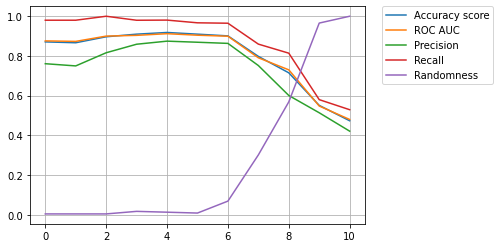

array([[0.87083333, 0.87587885, 0.76093085, 0.98      , 0.00434783],
       [0.86648551, 0.87330532, 0.74981974, 0.98      , 0.00434783],
       [0.89655797, 0.89999057, 0.81610244, 1.        , 0.00434783],
       [0.90978261, 0.90373168, 0.85906401, 0.97980769, 0.01721014],
       [0.9182971 , 0.91209984, 0.87453409, 0.98055556, 0.01304348],
       [0.90978261, 0.90446581, 0.8690579 , 0.96691087, 0.00869565],
       [0.90108696, 0.89938492, 0.86327453, 0.96488095, 0.06884058],
       [0.79782609, 0.79075647, 0.75169334, 0.85960817, 0.30144928],
       [0.71503623, 0.73006482, 0.60091671, 0.81396825, 0.56865942],
       [0.5509058 , 0.54785312, 0.51379635, 0.57996698, 0.96557971],
       [0.47355072, 0.48006951, 0.42118341, 0.52923493, 1.        ]])

In [49]:
hp_tuning('cvrds', 3)

0
1
2
3
4


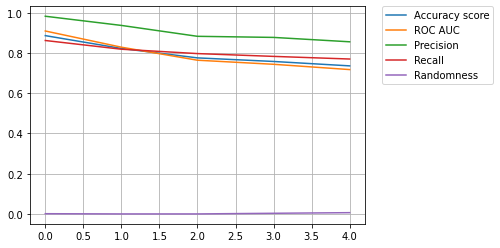

array([[0.88619518, 0.90925233, 0.98256254, 0.86199598, 0.00104167],
       [0.82252193, 0.82876279, 0.93693555, 0.81867042, 0.        ],
       [0.77555921, 0.76394828, 0.88279777, 0.79692693, 0.        ],
       [0.75778509, 0.74374274, 0.87737764, 0.78302821, 0.003125  ],
       [0.73588816, 0.71743709, 0.8555522 , 0.76992133, 0.00626096]])

In [54]:
hp_tuning('ttt', 1)

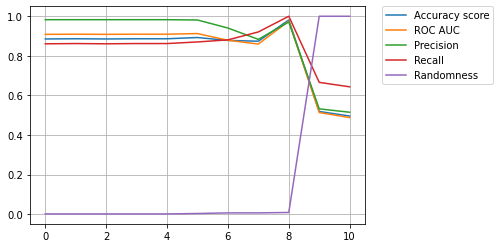

array([[0.88515351, 0.9085339 , 0.98256254, 0.86074027, 0.00104167],
       [0.88619518, 0.90925233, 0.98256254, 0.86199598, 0.00104167],
       [0.88515351, 0.9085339 , 0.98256254, 0.86074027, 0.00104167],
       [0.88619518, 0.90925233, 0.98256254, 0.86199598, 0.00104167],
       [0.88619518, 0.90925233, 0.98256254, 0.86199598, 0.00104167],
       [0.89245614, 0.91246402, 0.98102408, 0.87011322, 0.00313596],
       [0.87788377, 0.87858656, 0.94045215, 0.88062623, 0.00626096],
       [0.87372807, 0.85951465, 0.88316625, 0.92071058, 0.00626096],
       [0.98125   , 0.97537131, 0.97110844, 1.        , 0.00835526],
       [0.51881579, 0.51343272, 0.53201191, 0.6658145 , 1.        ],
       [0.49573465, 0.48787503, 0.51484207, 0.64336835, 1.        ]])

In [56]:
hp_tuning('ttt', 2)

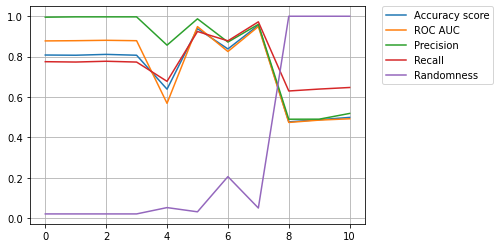

array([[0.80791667, 0.87781337, 0.99533578, 0.77491246, 0.02089912],
       [0.80688596, 0.87889838, 0.99692308, 0.77318137, 0.02089912],
       [0.8110636 , 0.88084103, 0.99692308, 0.77706667, 0.02089912],
       [0.806875  , 0.8788321 , 0.99692308, 0.77304883, 0.02089912],
       [0.63876096, 0.56874374, 0.85679566, 0.677575  , 0.05221491],
       [0.93844298, 0.94874409, 0.98720366, 0.92444295, 0.03132675],
       [0.83808114, 0.82532831, 0.87202668, 0.87816136, 0.20566886],
       [0.95516447, 0.94888501, 0.95974845, 0.97229306, 0.05007675],
       [0.47700658, 0.47397364, 0.48997164, 0.62978602, 1.        ],
       [0.48757675, 0.48551663, 0.49021241, 0.63931108, 1.        ],
       [0.49901316, 0.49212575, 0.51861764, 0.64709475, 1.        ]])

In [57]:
hp_tuning('ttt', 3)

### 7. Launching algorithm with best hyperparaneters

In [58]:
# alg 1 Congressional Voting Records Data Set
y_pred, y_real, metrics = alg_eval(dataset_shortname='cvrds', alg_n=1, threshold_subset= 0)
avg_m_1_c = avg_metrics(metrics)
print_metrics(avg_m_1_c)

Accuracy score: 0.9139
Roc AUC Score: 0.9107
Precision Score: 0.8751
Recall Score: 0.9822
Randomness: 0.0000


In [63]:
#alg 2 Congressional Voting Records Data Set
y_pred, y_real, metrics = alg_eval(dataset_shortname='cvrds', alg_n=2, threshold_subset= 0, threshold_intersec=0)
avg_m_2_c = avg_metrics(metrics)
print_metrics(avg_m_2_c)

Accuracy score: 0.9139
Roc AUC Score: 0.9107
Precision Score: 0.8751
Recall Score: 0.9822
Randomness: 0.0000


In [64]:
#alg 3 Congressional Voting Records Data Set
y_pred, y_real, metrics = alg_eval(dataset_shortname='cvrds', alg_n=3, threshold_subset= 0, threshold_intersec=0.4)
avg_m_3_c = avg_metrics(metrics)
print_metrics(avg_m_3_c)

Accuracy score: 0.9226
Roc AUC Score: 0.9166
Precision Score: 0.8745
Recall Score: 0.9889
Randomness: 0.0130


In [65]:
#alg 4 Congressional Voting Records Data Set
y_pred, y_real, metrics = bernoulliNB(dataset_shortname='cvrds')
avg_m_4_c = avg_metrics(metrics)
print_metrics(avg_m_4_c)

Accuracy score: 0.9098
Roc AUC Score: 0.9019
Precision Score: 0.8995
Recall Score: 0.9382
Randomness: 0.0000


In [66]:
# alg 1 Tic-Tac Toe dataset
y_pred, y_real, metrics = alg_eval(dataset_shortname='ttt', alg_n=1, threshold_subset= 0)
avg_m_1_t = avg_metrics(metrics)
print_metrics(avg_m_1_t)

Accuracy score: 0.8852
Roc AUC Score: 0.9085
Precision Score: 0.9826
Recall Score: 0.8607
Randomness: 0.0010


In [67]:
#alg 2 Tic-Tac Toe dataset
y_pred, y_real, metrics = alg_eval(dataset_shortname='ttt', alg_n=2, threshold_subset=0, threshold_intersec=0.8)
avg_m_2_t = avg_metrics(metrics)
print_metrics(avg_m_2_t)

Accuracy score: 0.9812
Roc AUC Score: 0.9754
Precision Score: 0.9708
Recall Score: 1.0000
Randomness: 0.0084


In [68]:
#alg 3 Tic-Tac Toe dataset
y_pred, y_real, metrics = alg_eval(dataset_shortname='ttt', alg_n=3, threshold_subset=0, threshold_intersec=0.7)
avg_m_3_t = avg_metrics(metrics)
print_metrics(avg_m_3_t)

Accuracy score: 0.9572
Roc AUC Score: 0.9503
Precision Score: 0.9618
Recall Score: 0.9735
Randomness: 0.0501


In [69]:
#alg 4 Tic-Tac Toe dataset
y_pred, y_real, metrics = bernoulliNB(dataset_shortname='ttt')
avg_m_4_t = avg_metrics(metrics)
print_metrics(avg_m_4_t)

Accuracy score: 0.6847
Roc AUC Score: 0.6489
Precision Score: 0.8014
Recall Score: 0.7391
Randomness: 0.0000


### 8. Find best algotithm

In [70]:
avg_metrics_с = np.vstack([avg_m_1_c, avg_m_2_c,avg_m_3_c,avg_m_4_c])
print(avg_metrics_с)

[[0.91394928 0.91074634 0.87511889 0.98222222 0.        ]
 [0.91394928 0.91074634 0.87511889 0.98222222 0.        ]
 [0.92264493 0.9166453  0.87453409 0.98888889 0.01304348]
 [0.90978261 0.90186147 0.89953409 0.93824675 0.        ]]


In [71]:
avg_metrics_ttt = np.vstack([avg_m_1_t, avg_m_2_t,avg_m_3_t,avg_m_4_t])
print(avg_metrics_ttt)

[[0.88515351 0.9085339  0.98256254 0.86074027 0.00104167]
 [0.98123904 0.97538195 0.97082872 1.         0.00835526]
 [0.95721491 0.95030227 0.96175425 0.97350313 0.05007675]
 [0.68473684 0.64893071 0.80139914 0.73911686 0.        ]]


Histogram plots

In [81]:
def hist_plot(data, name):
    x = np.arange(data.shape[0])
    dx = (np.arange(data.shape[1])-data.shape[1]/2.)/(data.shape[1]+2.)
    d = 1./(data.shape[1]+2.)


    fig, ax=plt.subplots()
    labels = ['Alg1','Alg2','Alg3','bNB']
    x_axis = np.arange(0, 4, 1)
    for i in range(data.shape[1]):
        ax.bar(x+dx[i],data[:,i], width=d)#, label="label {}".format(labels[i]))
    plt.xticks(x_axis,labels)
    plt.title(name)
    plt.legend(['Accuracy score', 'ROC AUC', 'Precision','Recall', 'Randomness'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid()
    plt.show()

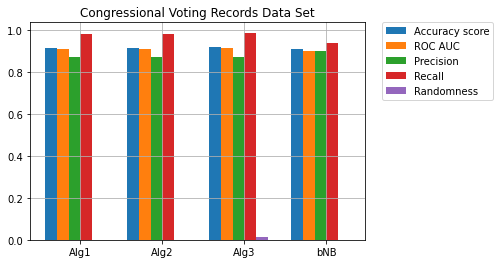

In [82]:
hist_plot(avg_metrics_с, name= 'Congressional Voting Records Data Set')

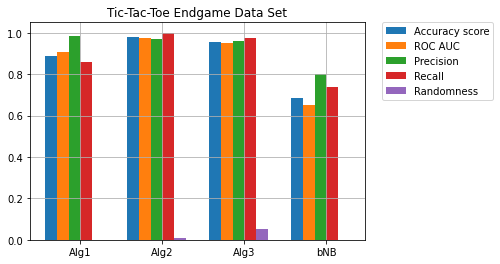

In [83]:
hist_plot(avg_metrics_ttt, name= 'Tic-Tac-Toe Endgame Data Set')

### 9. Results

In [84]:
print('Algorithm 3 is the best for dataset 1')
print_metrics(avg_m_3_c)

Algorithm 3 is the best for dataset 1
Accuracy score: 0.9226
Roc AUC Score: 0.9166
Precision Score: 0.8745
Recall Score: 0.9889
Randomness: 0.0130


In [86]:
print('Algorithm 2 is the best for dataset 2')
print_metrics(avg_m_2_t)

Algorithm 2 is the best for dataset 2
Accuracy score: 0.9812
Roc AUC Score: 0.9754
Precision Score: 0.9708
Recall Score: 1.0000
Randomness: 0.0084
